In [1]:
%load_ext autoreload
%autoreload 2

import time
from collections import deque, Counter

import numpy as np

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

from dm_control import mjcf
from dm_control import viewer

import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

from cartpole3d import CartPole3D
from rendering import display_video



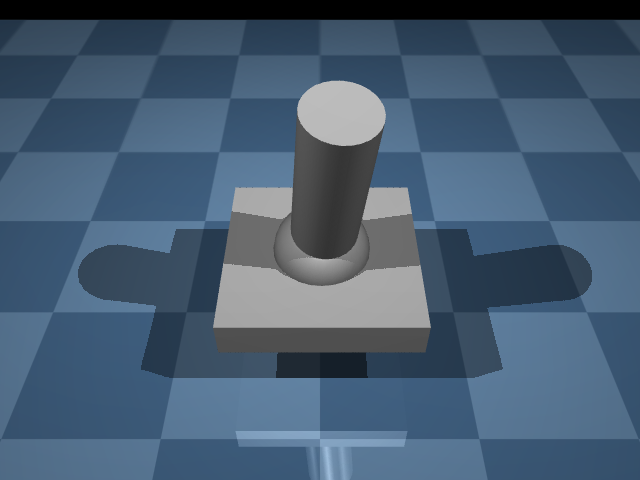

In [9]:
cartpole3d_env = CartPole3D(
    nr_movement_dimensions=2,
    force_magnitude=5000,
    physics_steps_per_step=0.1,
    reset_randomization_magnitude=0.1,
    slide_range=0.5,
    hinge_range=0.8,
    time_limit=3.0,
    step_reward_function=lambda time, action, state: 0, # (time if np.any(np.abs(np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0]) - time) < 0.002) else 0) + ((-10) if np.linalg.norm(action) > 0.99 else 0), #-np.linalg.norm(state[:4]) + time / 2,
    out_ouf_range_reward_function=lambda time, action, state: -10 + time * 3,
    time_limit_reward_function=lambda time, action, state: 10000,
)

cartpole3d_env.reset()

for _ in range(200):
    cartpole3d_env.step(np.array([0] * cartpole3d_env.nr_movement_dimensions))

cartpole3d_env.render()

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

eps = 1e-6

seed = time.time_ns() % (2**32)
np.random.seed(seed)
torch.manual_seed(seed)
print(f'seed is {seed}')

def step_reward(time, action, state):
    reward = 0

    reward += time
    
    reward -= np.linalg.norm(state[:4])
    
    return reward

env = CartPole3D(
    nr_movement_dimensions=2,
    cart_size=0.25,
    force_magnitude=5000,
    physics_steps_per_step=1,
    reset_randomization_magnitude=0.1,
    slide_range=100.5,
    hinge_range=1,
    time_limit=10.0,
    step_reward_function=step_reward, # (time if np.any(np.abs(np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0]) - time) < 0.002) else 0) + ((-10) if np.linalg.norm(action) > 0.99 else 0), #-np.linalg.norm(state[:4]) + time / 2,
    out_ouf_range_reward_function=lambda time, action, state: 100 * time**2 if time > 1 else time**2,# -10 + time * 3,
    time_limit_reward_function=lambda time, action, state: 100,
)
# env = gym.make("CartPole-v1")

gamma = 0.9

action_dist_sd = 0.05

minimum_learning_episodes = 10
timestep_discard_limit = 100

class Policy(nn.Module):
    def __init__(self, num_hidden_layers=4, hidden_size=32):
        super(Policy, self).__init__()
        
        modules = []

        in_dim = env.observation_space.shape[0]
        for _ in range(num_hidden_layers):
            linear = nn.Linear(in_dim, hidden_size)
            nn_init.kaiming_uniform_(linear.weight)
            nn_init.zeros_(linear.bias)
            
            norm = nn.LayerNorm(hidden_size)
            activation = nn.ReLU()

            modules.extend([linear, norm, activation])

            in_dim = hidden_size
        
        out_linear = nn.Linear(hidden_size, env.nr_movement_dimensions)
        nn_init.xavier_normal_(out_linear.weight)
        nn_init.zeros_(out_linear.bias)

        activation = nn.Tanh()
        
        modules.extend([out_linear, activation])

        self.fnn = nn.Sequential(*modules)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        return self.fnn(x)


    

def select_action(policy, state, pred_log: list[np.ndarray]):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    pred = policy(state)
    pred_log.append(pred.detach().cpu().numpy())
    
    action_dist = torch.distributions.Normal(pred, action_dist_sd)
    action = action_dist.sample()
    policy.saved_log_probs.append(action_dist.log_prob(action))
    
    return action.detach().cpu().numpy().squeeze(0)


def finish_episode(policy, optimizer):
    R = 0
    policy_loss = []
    returns = deque()
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.appendleft(R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]
    

def main():
    print(f'Model has {sum(p.numel() for p in Policy().parameters() if p.requires_grad)} parameters')
    
    best_total_reward = 0

    for i_trial in range(1000):
        print(f'=====  Trial nr {i_trial:>4}  =====')
        trial_best_reward = 0
        
        policy = Policy()
        optimizer = optim.Adam(policy.parameters(), lr=1e-3)

        timestep = 0
        for i_episode in range(2000):
            if i_episode > minimum_learning_episodes and timestep < timestep_discard_limit:
                break
            
            state, _ = env.reset()
            ep_reward = 0
            pred_log = []
            info = {}
            for timestep in range(1, 10000):  # Don't infinite loop while learning
                action = select_action(policy, state, pred_log)
                state, reward, done, truncated, info = env.step(action)
                
                policy.rewards.append(reward)
                ep_reward += reward
                if done:
                    break
    
            finish_episode(policy, optimizer)

            if ep_reward > trial_best_reward:
                trial_best_reward = ep_reward
            
            if ep_reward > best_total_reward:
                best_total_reward = ep_reward
                torch.save(policy, 'best.pt')
            
            if i_episode % 1 == 0:
                def stringify_np_array(arr):
                    return ", ".join([f"{x:> 2.4f}" for x in arr[0]])
                    
                print(f'{i_episode:>4}   '
                      f'Total reward: {ep_reward:>7.2f} \t '
                      f'Time (Actions): {env.get_time():7.4f} ({timestep:>5})      '
                      f' {info["termination_reason"].split("_")[0]}\t     '
                      f'Pred mean | std | min | max:     '
                      f'{stringify_np_array(np.mean(pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.std(pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.min(pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.max(pred_log, axis=0))}')
            if False:
                print("Solved! "
                      "the last episode runs to {} time steps!".format(t))
                break
main()

seed is 3953796216
Model has 3778 parameters
=====  Trial nr    0  =====
   0   Total reward: -305.10 	 Time (Actions):  0.0840 (   42)       hinge	     Pred mean | std | min | max:      0.2161, -0.8014   |    0.1460,  0.0409   |   -0.0670, -0.8597   |    0.3924, -0.6201
   1   Total reward: -313.00 	 Time (Actions):  0.0780 (   39)       hinge	     Pred mean | std | min | max:      0.2435, -0.8437   |    0.0746,  0.0243   |    0.1279, -0.8875   |    0.4352, -0.8107
   2   Total reward: -315.72 	 Time (Actions):  0.0780 (   39)       hinge	     Pred mean | std | min | max:      0.1105, -0.8579   |    0.1053,  0.0085   |   -0.1725, -0.8703   |    0.1997, -0.8335
   3   Total reward: -442.11 	 Time (Actions):  0.0780 (   39)       hinge	     Pred mean | std | min | max:     -0.0061, -0.8614   |    0.0812,  0.0114   |   -0.1786, -0.8890   |    0.1252, -0.8426
   4   Total reward: -458.06 	 Time (Actions):  0.0840 (   42)       hinge	     Pred mean | std | min | max:     -0.1543, -0.7910  

KeyboardInterrupt: 

In [75]:
def main():
    duration = 5   # (Seconds)
    framerate = 30  # (Hz)
    video = []
     
    last_switch = 0
    
    policy = torch.load('best.pt')

    # env = CartPole3D(
    #     nr_movement_dimensions=2,
    #     cart_size=0.25,
    #     force_magnitude=5000,
    #     physics_steps_per_step=1,
    #     reset_randomization_magnitude=0.1,
    #     slide_range=1.5,
    #     hinge_range=1,
    #     time_limit=10.0,
    #     step_reward_function=step_reward, # (time if np.any(np.abs(np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0]) - time) < 0.002) else 0) + ((-10) if np.linalg.norm(action) > 0.99 else 0), #-np.linalg.norm(state[:4]) + time / 2,
    #     out_ouf_range_reward_function=lambda time, action, state: 0,#100 * time**2 if time > 1 else time**2,# -10 + time * 3,
    #     time_limit_reward_function=lambda time, action, state: 100,
    # )
    
    physics = env.physics
    
    state, _ = env.reset()
    
    trace = []
    
    while physics.data.time < duration:
        action = select_action(policy, state, [])
        trace.append((state, action))
        state, reward, done, _, _ = env.step(action)
    
        if len(video) < physics.data.time * framerate:
            
            pixels = physics.render(width=640, height=480, camera_id=-1)
            video.append(pixels.copy())
    
    trace_states = [t[0] for t in trace]
    trace_actions = [t[1] for t in trace]
    print(np.mean(trace_actions, axis=0), np.std(trace_actions, axis=0))
    return display_video(video, framerate)

main()

[0.01589029 0.04808658] [0.35874227 0.15275286]


C:\Users\domin\AppData\Local\Temp\ipykernel_1928\2271421933.py:7: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


In [48]:
bucket_size = 25
for i in range(0, len(trace), bucket_size):
    print(f'{i:>5}: \t\t {str(trace_states[i]):<80} {dict(Counter(trace_actions[i:i+bucket_size]))}')

    0: 		 [0.00301361 0.00367415 0.         0.        ]                                    {0: 14, 1: 11}
   25: 		 [ 0.00292876  0.00401671 -0.10202983  0.28135216]                                {1: 11, 0: 14}
   50: 		 [-0.00295657  0.02047702 -0.20547259  0.57582806]                                {0: 11, 1: 14}
   75: 		 [-0.01196818  0.04687255 -0.11103751  0.36473102]                                {1: 14, 0: 11}
  100: 		 [-0.01569649  0.0619232  -0.02066444  0.1907396 ]                                {0: 12, 1: 13}
  125: 		 [-0.01742692  0.07570222 -0.00118233  0.23108436]                                {1: 16, 0: 9}
  150: 		 [-0.01284353  0.0773893   0.21876811 -0.25992532]                                {1: 16, 0: 9}
  175: 		 [ 0.00128048  0.05831053  0.44054853 -0.76694037]                                {1: 13, 0: 12}
  200: 		 [ 0.02666284  0.01235996  0.46714981 -0.79121752]                                {0: 14, 1: 11}
  225: 		 [ 0.04588013 -0.01583977  0.36605822 -

In [ ]:
physics.data.qpos

array([ 0.80046674, -1.047949  ])

In [122]:
np.concatenate([physics.data.qpos, physics.data.qvel])

array([-0.02168953, -0.03073212,  0.38963361, -0.20229654,  0.22114658,
        0.18125404, -1.93815623,  2.08265143])